<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/src/dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_original_RU_merge_2ch_and_ok.csv')
df.head(10)

,comment,toxic
0,скотина! что сказать,1
1,я сегодня проезжала по рабочей и между домами ...,0
2,очередной лохотрон. зачем придумывать очередно...,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",0
4,а когда мы статус агрогородка получили?,0
5,2 августа поздно вечером нашли вот такую потер...,0
6,вчера надыбала новые стикеры #u2a94ec7fabs#,0
7,заколоть этого плешивого урода что бы крякнул ...,1
8,а еще на стоянке никто не проверяет безопаснос...,0
9,"красота..!! если есть, что показать??!! почему...",0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262702 entries, 0 to 262701
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   comment  262702 non-null  object
 1   toxic    262702 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ MB


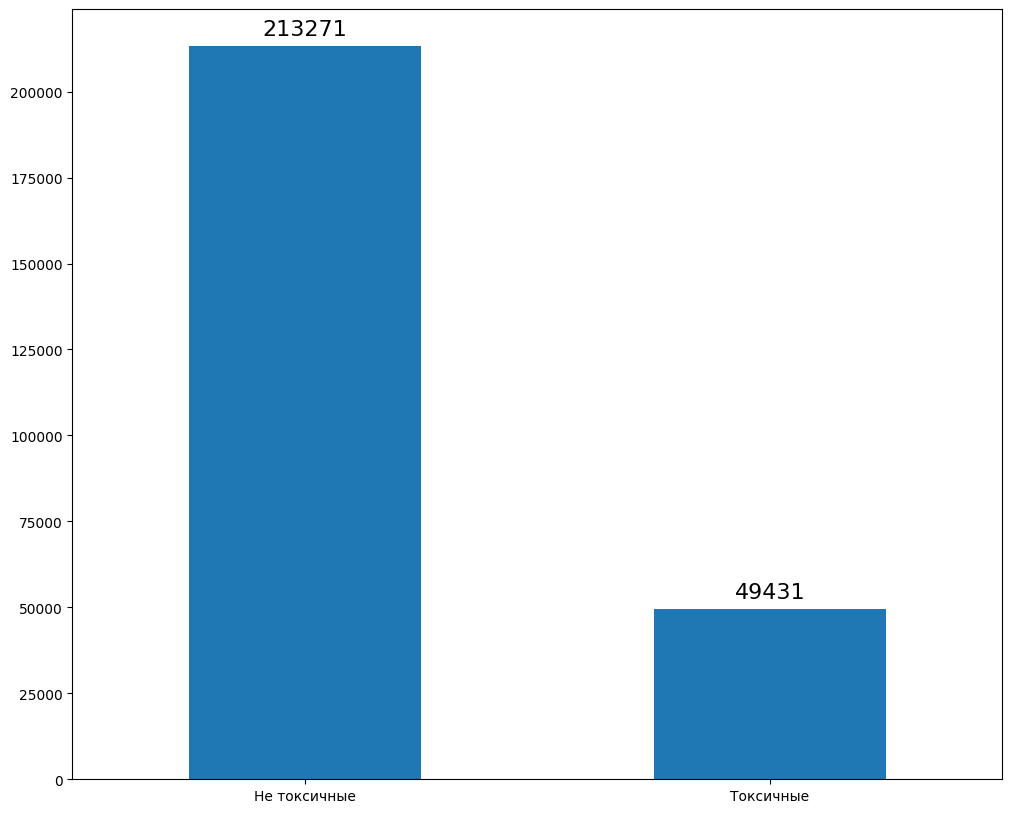

In [28]:
fig, ax = plt.subplots(figsize=(12, 10))
toxic = (df['toxic'].value_counts()).plot(kind='bar')
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0, fontsize=10)
# plt.grid(color='lightblue', linestyle=':')
# plt.text(0, 1, (df['toxic'].value_counts())[0], horizontalalignment='center', fontsize=21, color='yellow')
# plt.text(1, 1, (df['toxic'].value_counts())[1], horizontalalignment='center', fontsize=21, color='yellow')
# plt.show()

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:}".format(y_value)

        # Create annotation
        ax.annotate(
            
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va,
            fontsize=16,
            )                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

In [29]:
df['counts_word']= df['comment'].str.split().str.len()
df

,comment,toxic,counts_word
0,скотина! что сказать,1,3
1,я сегодня проезжала по рабочей и между домами ...,0,29
2,очередной лохотрон. зачем придумывать очередно...,0,54
3,"ретро дежавю ... сложно понять чужое сердце , ...",0,12
4,а когда мы статус агрогородка получили?,0,6
...,...,...,...
262697,Вонючий совковый скот прибежал и ноет. А вот и...,1,15
262698,А кого любить? Гоблина тупорылого что-ли? Или ...,1,17
262699,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0,43
262700,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1,44


In [30]:
df["counts_word"].mean()

13.34759537422631

In [31]:
df["counts_word"].quantile(.80)


18.0

In [32]:
q95=df["counts_word"].quantile(.95)
q95

43.0

<Axes: >

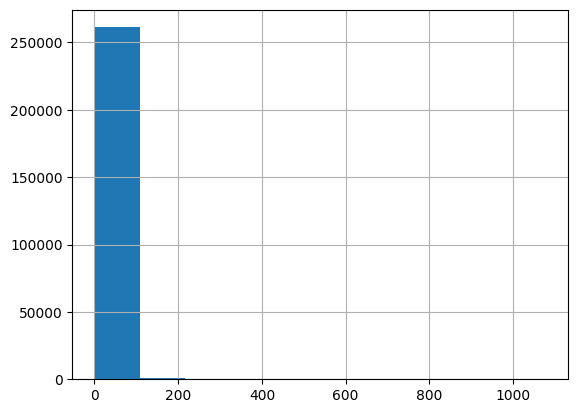

In [33]:
df["counts_word"].hist()

<Axes: >

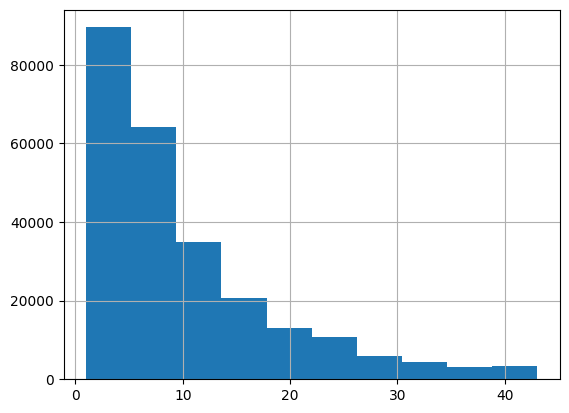

In [34]:
df[df["counts_word"]<=q95]['counts_word'].hist()

In [35]:
def q75(x):
    return x.quantile(0.75)
def q95(x):
    return x.quantile(0.95)

In [36]:
df['counts_word'].describe()

count    262702.000000
mean         13.347595
std          18.200586
min           1.000000
25%           4.000000
50%           8.000000
75%          15.000000
max        1078.000000
Name: counts_word, dtype: float64

In [23]:
df['counts_word_group'] = pd.cut(df['counts_word'],5)

df.groupby('counts_word_group',dropna=False)['counts_word'].agg(['count','mean',q75,q95])

,count,mean,q75,q95
counts_word_group,,,,
"(-0.077, 216.4]",262596,13.207829,15.00,43.0
"(216.4, 431.8]",87,298.206897,341.50,402.8
"(431.8, 647.2]",11,534.272727,574.00,608.0
"(647.2, 862.6]",6,701.000000,725.25,775.5
"(862.6, 1078.0]",2,1045.000000,1061.50,1074.7
